(4160.3665846345793,
 10409.514805718516,
 4090.1331159361812,
 10558.524913631312)

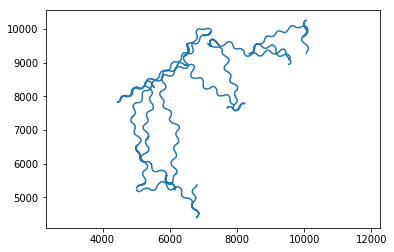

In [1]:
%matplotlib inline

import numpy as np
import numba

import matplotlib.pylab as plt
import matplotlib.cm as cm
from matplotlib import animation

from IPython.display import HTML

from tierpsy_features.postures import get_curvature, _h_curvature, \
get_eigen_projections, get_length, _h_curvature_test
from tierpsy_features.velocities import _h_ax_range


data = np.load('./data/worm_example.npz')
skeletons = data['skeleton']
dorsal_contours = data['dorsal_contour']
ventral_contours = data['ventral_contour']

plt.plot(skeletons[:, 25, 0], skeletons[:, 25, 1])
plt.axis('equal')

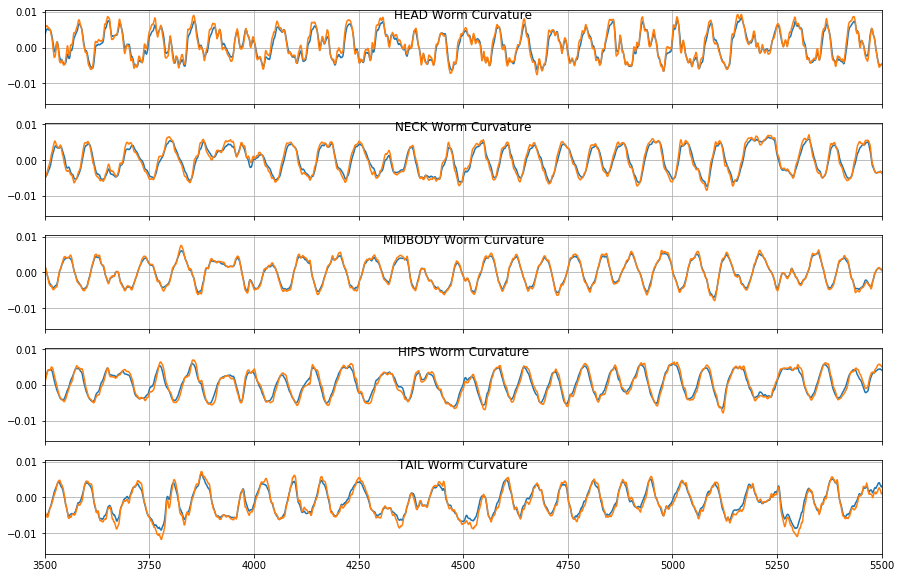

In [2]:
d_r = (3500, 5500)

f, axs = plt.subplots(5, sharex=True, sharey=True, figsize = (15, 10))

skel_lengths = get_length(skeletons)
for points_window in [5, 4]:#range(4, 6):
    segment_curvatures = get_curvature(skeletons, points_window, lengths=None)
    
    for ax, (p, curv) in zip(axs, segment_curvatures.items()):  
        ax.plot(curv) 
        ax.set_title(p.upper() + ' Worm Curvature', y=0.85)
        ax.grid('on')
    plt.xlim(d_r)

/Users/ajaver/miniconda/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


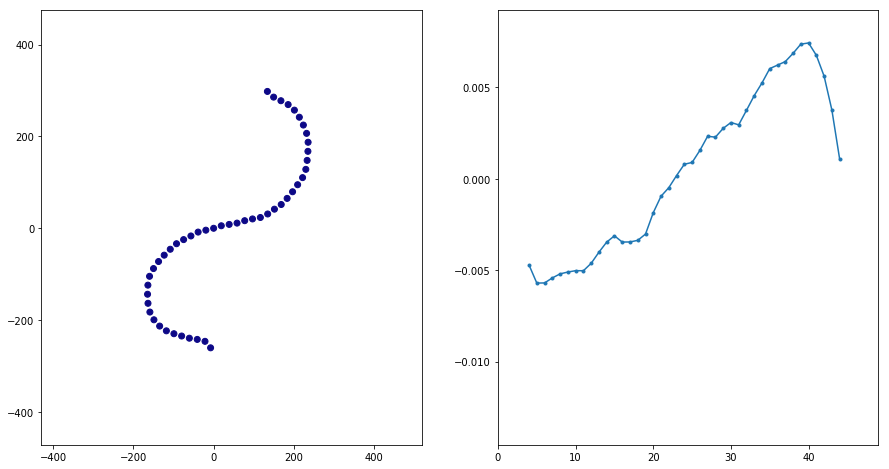

In [3]:
curvatures = _h_curvature(skeletons, points_window, lengths=None)

ini_t = d_r[0]
fin_t = d_r[1]

skel_a = skeletons[ini_t:fin_t]
skel_a = skel_a - skel_a[:, 25, :][:, None, :]
angs = curvatures[ini_t:fin_t]

x_angles = np.arange(angs.shape[1]) + points_window

x_range, y_range = _h_ax_range(skel_a)
fig = plt.figure(figsize = (15, 8))
ax_skels = plt.subplot(1,2,1)

ax_bends = plt.subplot(1,2,2)
l_bends, = ax_bends.plot([], [], '.-')
ax_bends.set_xlim(0, angs.shape[1] + 2*points_window)

curv_range = (np.nanmin(curvatures), np.nanmax(curvatures))
ax_bends.set_ylim(curv_range)

#animation function. This is called sequentially
def _animate(i):
    x = skel_a[i, :, 0]
    y = skel_a[i, :, 1]
    curv = curvatures[i]
    /
    curv_n = (curv-curv_range[0])/(curv_range[1] - curv_range[0])
    curv_n = np.pad(curv_n, (points_window,points_window), 'edge')
    curv_n = np.clip(curv_n, 0, 1)
    c = cm.plasma(curv_n)
    
    ax_skels.clear()
    ax_skels.scatter(x, y, c=c)
    ax_skels.set_xlim(*x_range)
    ax_skels.set_ylim(*y_range)
    
    l_bends.set_data(x_angles, angs[i])
    return l_bends,


# call the animator. blit=True means only re-draw the parts that have changed.
tot = skel_a.shape[0]
anim = animation.FuncAnimation(fig, 
                               _animate,
                               interval=50, 
                               frames = tot,
                               blit=True);
HTML(anim.to_html5_video())

(7505, 41)
(7505, 49)


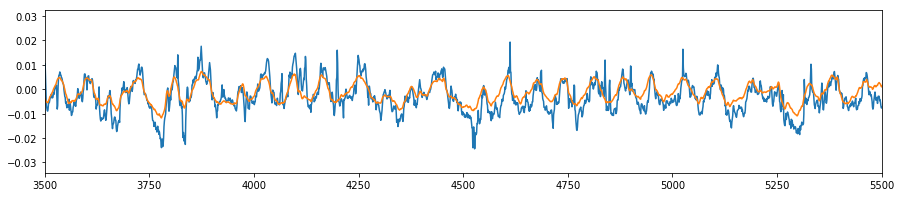

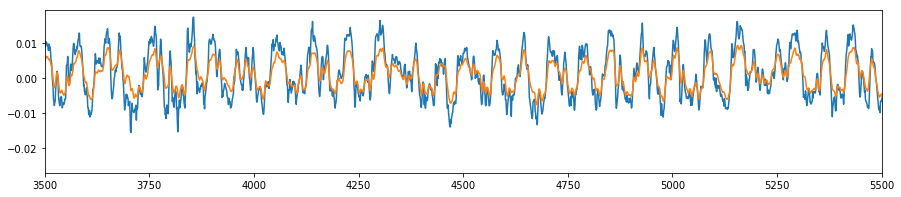

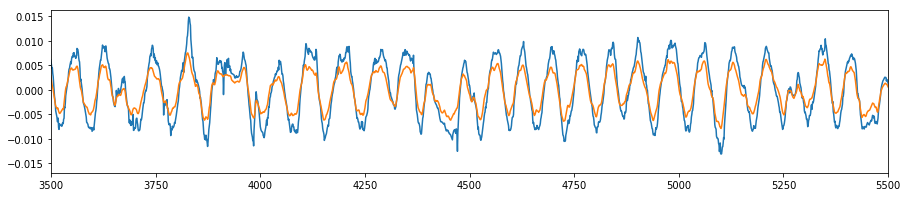

In [4]:


curvatures_fit = _h_curvature_test(skeletons)

xlim = d_r

nn = points_window-1
mid = int(curvatures.shape[1]/2)

plt.figure(figsize = (15, 3))
plt.plot(curvatures_fit[:, -nn])
plt.plot(curvatures[:, -1]) 
plt.xlim(xlim)

plt.figure(figsize = (15, 3))
plt.plot(curvatures_fit[:, nn])
plt.plot(curvatures[:, 0]) 
plt.xlim(xlim)

plt.figure(figsize = (15, 3))
plt.plot(curvatures_fit[:, 25])
plt.plot(curvatures[:, mid]) 
plt.xlim(xlim)

print(curvatures.shape)
print(curvatures_fit.shape)

(41,)
(49,)


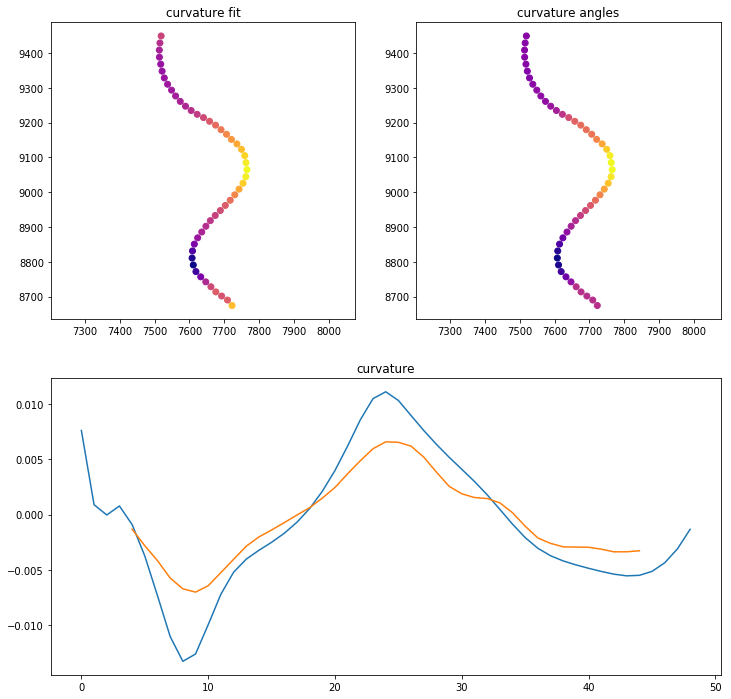

In [5]:
t = 2340
skel = skeletons[t]
curv_f = curvatures_fit[t]
curv = curvatures[t]

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
x = skel[:, 0]
y = skel[:, 1]
curv_range = (np.nanmin(curv_f), np.nanmax(curv_f))
curv_n = (curv_f - curv_range[0])/(curv_range[1] - curv_range[0])
c = cm.plasma(curv_n)
plt.scatter(x, y, c=c)
plt.title('curvature fit')
plt.axis('equal')

plt.subplot(2,2,2)
x = skel[:, 0]
y = skel[:, 1]
curv_range = (np.nanmin(curv), np.nanmax(curv))
curv_n = (curv - curv_range[0])/(curv_range[1] - curv_range[0])
curv_n = np.pad(curv_n, (points_window,points_window), 'edge')
c = cm.plasma(curv_n)
plt.scatter(x, y, c=c)
plt.title('curvature angles')
plt.axis('equal')

plt.subplot(2,1,2)
plt.plot(curv_f)
plt.plot(np.arange(curv.size) + points_window, curv)
plt.title('curvature')

print(curv.shape)
print(curv_f.shape)



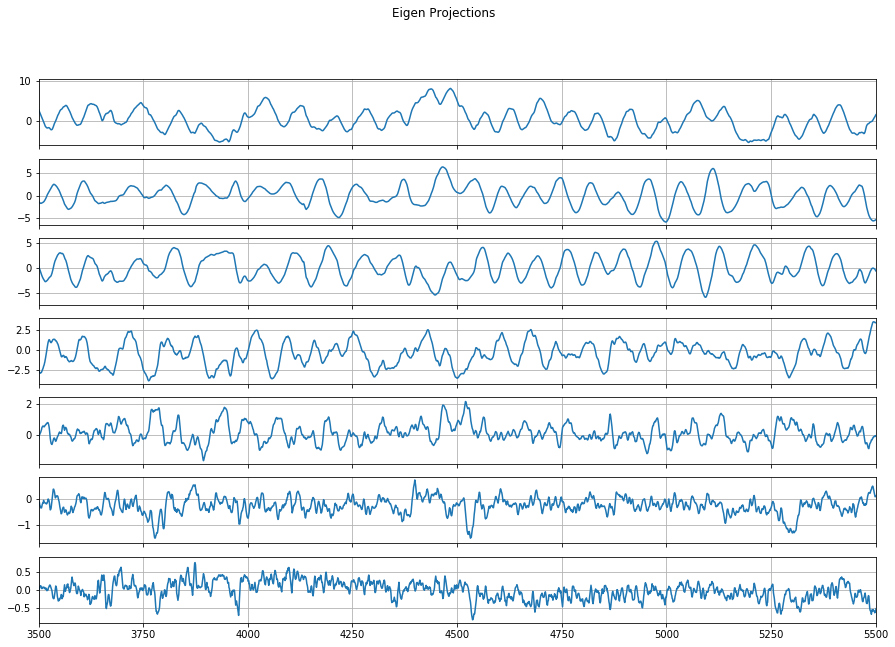

In [6]:
eigen_projections = get_eigen_projections(skeletons)


xlim = d_r

f, axs = plt.subplots(eigen_projections.shape[1], sharex=True, figsize = (15, 10))

for ii, ax in enumerate(axs):  
    ax.plot(eigen_projections[:, ii])
    ax.grid('on')
plt.xlim(xlim)
plt.suptitle('Eigen Projections')

(4543.9765976656072, 7708.7699267804464, 4535.605923678947, 10445.830384576579)

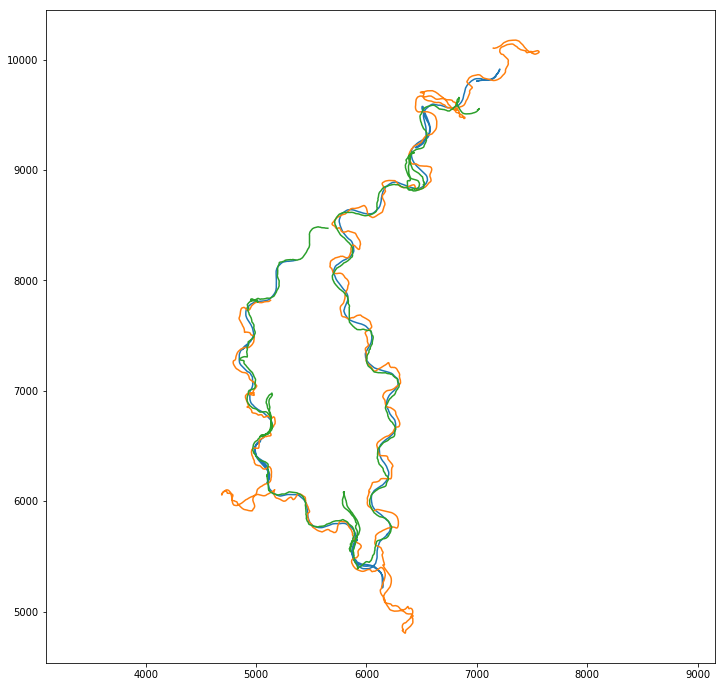

In [7]:
tt = np.arange(d_r[0], d_r[1])

ext_ind = 1

plt.figure(figsize=(12,12))
plt.plot(skeletons[tt, 25, 0], skeletons[tt, 25, 1])
plt.plot(skeletons[tt, ext_ind-1, 0], skeletons[tt, ext_ind-1, 1])
plt.plot(skeletons[tt, -ext_ind, 0], skeletons[tt, -ext_ind, 1])
plt.axis('equal')